# 二値データを整える

データは様々な形で与えられる。その中でもよく扱うのは、二値（バイナリ）データ。本当にゼロとイチでの表現なので、読み書きの際は一定の注意が必要であるが、何も難しいことはない。

__目次：__
- <a href="#overview">データセットの概要</a>
- <a href="#input_check">入力パターンを調べる</a>
- <a href="#label_check">ラベルを調べる</a>
- <a href="#finalprep">作業用のデータを仕上げる</a>
___

<a id="overview"></a>
## データセットの概要

二値データの事例は数えきれぬほどあるが、今回は著名なMNIST手書き文字のデータに着目する。

<img src="img/ex_MNIST.png" alt="Stimuli Image" />

ダウンロード方法はいくつもあるが、Y. LeCun氏のサイト( http://yann.lecun.com/exdb/mnist/ )から入手することが多い。彼らの説明には、

> *"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image."*

とあり、その中身を収容するファイルが下記の4つである。

> train-images-idx3-ubyte.gz:  training set images (9912422 bytes)

> train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)

> t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)

> t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

いずれも__IDX__という二値形式で保存されている。まずは圧縮されたファイルを解凍する。

```
$ cd data/MNIST
$ gunzip train-images-idx3-ubyte.gz
$ gunzip train-labels-idx1-ubyte.gz
$ gunzip t10k-images-idx3-ubyte.gz
$ gunzip t10k-labels-idx1-ubyte.gz
```
残るのは肝心のバイナリデータだけだ。

___

<a id="input_check"></a>
## 入力パターンを調べる

まずは、訓練データのファイルを開くことにしよう。


In [24]:

import numpy as np
import matplotlib.pyplot as plt

toread = "data/MNIST/train-images-idx3-ubyte"

f_bin = open(toread, mode="rb")

print(f_bin)


<_io.BufferedReader name='data/MNIST/train-images-idx3-ubyte'>


ここで、正しく読み込めているかどうか確かめる必要が出てくる。その唯一の方法は、データの提供者が「あるはずだ」という内容と照合することである。
LeCun等の説明より：

```
TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
```

ここでいう「offset」とは、ファイル開始点から何バイト読み進んだか示す数値である。ゼロならば一バイトも読んでおらず、1バイト目を目前にする地点である。offsetが0004であれば5バイト目、0008であれば9バイト目など、以下同様。期待どおりの中身が読み込めているかチェックしてみよう。

In [25]:

print("First four bytes:") # should be magic number, 2051.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


First four bytes:
bytes:  b'\x00\x00\x08\x03'
 int:  2051


ここに出てきたPythonのバイトデータ`b'\x00\x00\x08\x03'`は、最初の4バイトを十六進法(hexadecimal)の表記で示したものである。上記の表の一行目の「value」、つまり``0x00000803``と一致しているので、一安心。これらの``\x``はただ単にバイトの区切りを表している。思い出してみると、十六進法の2桁を使うと、$0, 1, 2, \ldots$から$(15 \times 16^{1} + 15 \times 16^{0}) = 255$までの整数を表現することができる。二進法の8桁、つまり8ビット（＝1バイト）と同じである。さて、十進法に変換して$3 \times 16^{0} + 8 \times 16^{2} = 2051$が得られるので、期待どおりの「magic number」である。

次は、`read`というメソッドを使い、4バイトずつ読み進めるようにして、残りの内容を確認していく。

In [26]:

print("Second four bytes:") # should be number of imgs = 60000
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Second four bytes:
bytes:  b'\x00\x00\xea`'
 int:  60000


In [27]:

print("Third four bytes:") # should be number of rows = 28
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Third four bytes:
bytes:  b'\x00\x00\x00\x1c'
 int:  28


In [28]:

print("Fourth four bytes:") # should be number of cols = 28
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Fourth four bytes:
bytes:  b'\x00\x00\x00\x1c'
 int:  28


これでもっとも重要なファイル情報を無事に入手できた。これを使って、肝心の入力パターンを取り出していくことにしよう。幸いにも、デジタル画像の画素値なので、中身のもっともらしさは目視でほぼ確認できる。

In [29]:

n = 60000 # (anticipated) number of images.
d = 28*28 # number of entries (int values) per image.
times_todo = 20 # number of images to view.
bytes_left = d
data_x = np.zeros((d,), dtype=np.uint8) # initialize.


データの提供者の説明より：

> *"Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black)."*

つまり、画素値が0〜255の整数値を取り、2次元画像の一行ずつ読んでいくことになる。値の範囲がわかっているので、`uint8`(無符号の1バイト整数)のデータ型とする。まだ読んでいない中身として、

```
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
```
と1バイトずつファイルの最後まで読んでいくと、ちょうど60000枚の画像の全画素を読み込むことになるはずである。1枚につき画素数が$28 \times 28 = 784$である。

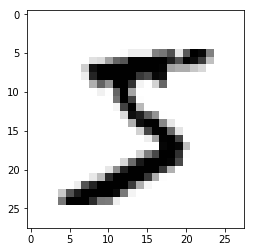

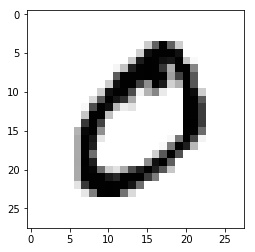

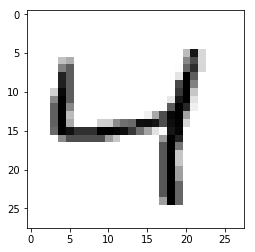

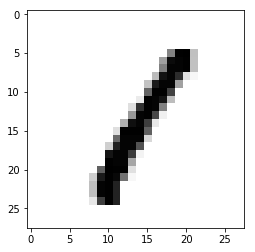

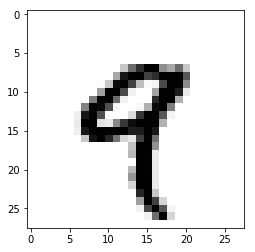

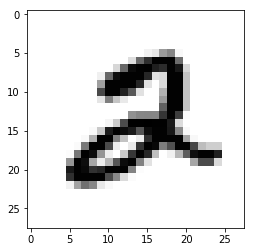

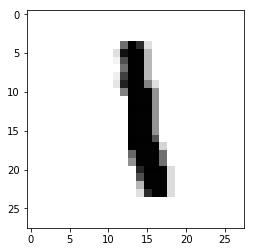

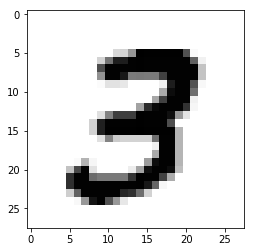

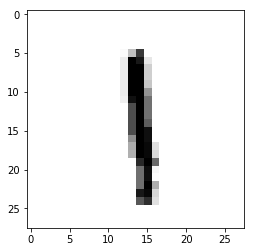

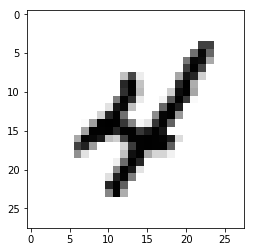

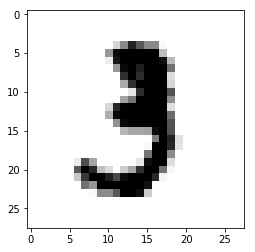

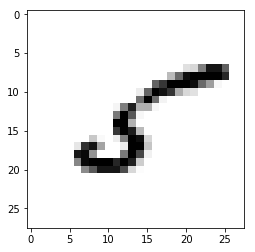

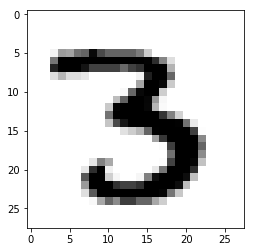

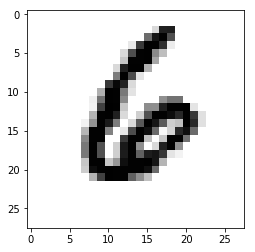

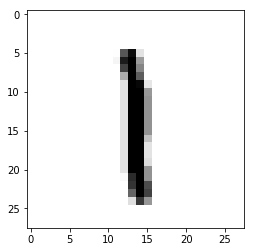

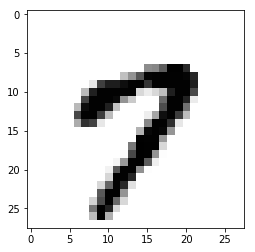

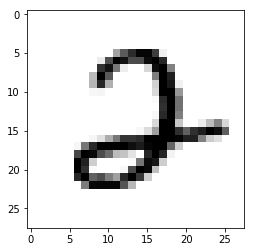

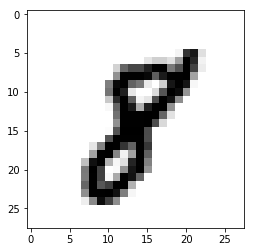

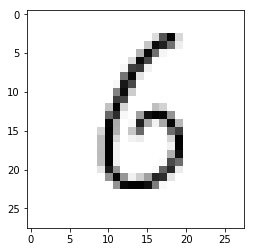

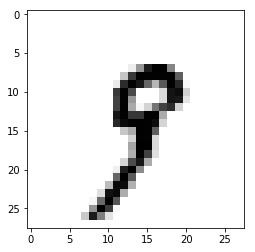

Successfully closed.


In [30]:

for t in range(times_todo):

    idx = 0
    while idx < bytes_left:
        # Iterate one byte at a time.
        b = f_bin.read(1)
        data_x[idx] = int.from_bytes(b, byteorder="big", signed=False)
        idx += 1

    img_x = data_x.reshape( (28,28) ) # populate one row at a time.
    
    # binary colour map highlights foreground (black) against background(white)
    plt.imshow(img_x, cmap=plt.cm.binary)
    
    if t < 10:
        plt.savefig(("MNIST_train_"+str(t)+".png"))
    plt.show()


f_bin.close()
if f_bin.closed:
    print("Successfully closed.")


### 練習問題 (A):

0. 上記のコードに出没する`int`のメソッド`from_bytes`を使うとき、引数`signed`を`False`から`True`へ変えてみてください。変換の結果が変わるか。変わる場合は、例示しながら説明すること。なぜその変化が起こるかも併せて説明すること。

0. 同様に`byteorder`を`"big"`から`"little"`へ変換し、何がどう変わるか調べてみてください。背景は`help(int.from_bytes)`を参照すること。

0. 多数のカラーマップが提供されている( https://matplotlib.org/users/colormaps.html )。上記コード内の`binary`に代わって、たとえば`gray`、`bone`、`pink`などほかの配色方法を試してみてください。

0. コメント記号で無効になっている`savefig`を「活き」の状態にし、最初の十枚の画像をディスクに保存すること。また、テスト用のデータについても同様の操作を行うこと（ファイル名は適宜変更すること）。

___

<a id="label_check"></a>
## ラベルを調べる

「何が書いてあるか」という典型的な識別課題を見据えて、「事例」としての画像が正しく読み込まれている模様である。正解ラベルは`train-labels-idx1-ubyte`という別のファイルに格納されているため、次はラベルに焦点を当てる。最初の`times_todo`枚の画像と対応するはずのラベルを照らし合わせることにしよう。

In [72]:
toread = "data/MNIST/train-labels-idx1-ubyte"

f_bin = open(toread, mode="rb")

print(f_bin)

<_io.BufferedReader name='data/MNIST/train-labels-idx1-ubyte'>


正解ラベルのファイルについては、再びLeCun等の説明を参考にする：

```
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
```

最初の8バイトを見ていく。

In [73]:

print("First four bytes:") # should be magic number, 2049.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big"))


First four bytes:
bytes:  b'\x00\x00\x08\x01'
 int:  2049


In [74]:

print("Second four bytes:") # should be number of observations, 60000.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big"))


Second four bytes:
bytes:  b'\x00\x00\xea`'
 int:  60000


以降はデータだけである。ラベルの値は0から9までの整数値を取るという。事例とラベルが一致していることを確かめる。

In [75]:
def seek(offset):
    f_bin.seek(offset + 8)
    b = f_bin.read(1)
    mylabel = int.from_bytes(b, byteorder="big", signed=False)
    print(mylabel)
    print("Label =" + str(mylabel) + " for offset = " + str(offset))

seek(1)

# for t in range(times_todo):

#     b = f_bin.read(1)
#     mylabel = int.from_bytes(b, byteorder="big", signed=False)
    
#     print("Label =", mylabel)
    

Label = 5
Label = 0
Label = 4
Label = 1
Label = 9
Label = 2
Label = 1
Label = 3
Label = 1
Label = 4
Label = 3
Label = 5
Label = 3
Label = 6
Label = 1
Label = 7
Label = 2
Label = 8
Label = 6
Label = 9


### 練習問題 (B):

0. 最初の10枚分のラベルを表示し、先ほど調べた画像の中身と合っているかどうか確かめること（訓練データと検証データ、両方とも）。

0. （おまけ） 上記のごとく`read`を使うと一方的に前進するだけだが、`seek`というメソッドを使うことで任意のバイトオフセットに飛ぶことができて、便利である。上の例でいうと、`f_bin.seek(0)`でファイル開始点に戻り、`f_bin.seek(8)`で最初のラベルを読み込む直前の地点へ移ることができる（最初の8バイトは補足情報）。この点を念頭において、`seek`を用いて、$k$という整数を与えられたときに$k$番目の画像の正解ラベルを表示するような関数を造りなさい。

0. （おまけ） 同様に、`seek`を使って$k$番目の画像を表示するような関数も造りなさい。
___

<a id="finalprep"></a>
## 作業用のデータを仕上げる

やや粗雑ではあったが、先ほどのようにデータをざっくりチェックすることで、正しく読み込めているかどうかは概ねわかる。

次は、機械学習という「作業」に使うことを前提に、高速に読める形式にすべてのデータを換えることにする。先ほどのやり方では、1バイトずつ読むのに一定の時間がかかるのだが、Python特有のバイナリ形式に変換すると、きわめて高速に読み込むことができる（但し、読むマシンと書くマシンが同一であることとする）。

第一歩として、訓練データからすべての画像分の画素値を読み込んでおく。

In [77]:
toread = "data/MNIST/t10k-images-idx3-ubyte"
n = 10000
d = 28*28
bytes_left = n * d
data_X = np.empty((n*d,), dtype=np.uint8)

with open(toread, mode="rb") as f_bin:

    f_bin.seek(16) # go to start of images.
    idx = 0
    
    print("Reading binary file...", end=" ")
    while bytes_left > 0:
        b = f_bin.read(1)
        data_X[idx] = int.from_bytes(b, byteorder="big", signed=False)
        bytes_left -= 1
        idx += 1
    print("Done reading...", end=" ")
print("OK, file closed.")


Reading binary file... Done reading... OK, file closed.


無符号の整数`uint8`型を使い、 一つの長いベクトル（配列）に全画像のデータを羅列した。いくつかの統計量を見てみよう。

In [78]:
print("Min:", np.min(data_X))
print("Mean:", np.mean(data_X))
print("Median:", np.median(data_X))
print("Max:", np.max(data_X))
print("StdDev:", np.std(data_X))

print(np.bincount(data_X))


Min: 0
Mean: 33.7912244898
Median: 0.0
Max: 255
StdDev: 79.1724632223
[6328781    3832    5756    6100    6371    6635    6236    6587    4952
    6412    6055    5832    4956    6808    4436    4707    4789    4477
    4584    5911    5113    6097    4774    3685    4239    4993    4051
    3884    4098    5828    3818    4281    4805    2634    3214    3441
    3655    4109    4480    2985    3269    4555    3623    3546    3102
    3441    2883    4012    3330    2834    4107    4016    2319    3276
    2997    3033    3795    4958    2333    2945    2874    2925    3198
    3856    8188    2528    2910    2665    2724    2852    3335    3020
    2873    3113    2308    2605    2910    2326    3090    2973    2421
    2929    3664    2439    4267    4117    3955    2161    2734    2895
    2032    2924    3089    2891    2739    2809    2813    2314    2723
    2931    2548    2348    3876    2451    2738    2411    3011    2687
    3021    2943    2655    2625    2999    3422    37

ここで注意すべきことがある。識別機を設計するときに使うモデルにもよるが、入力ベクトルの数値が大きすぎると、後の計算では不都合である。今回のデータをそのままにしておくと$\{0,1,\ldots,255\}$から値を取るが、このような数値を指数関数にかますモデル（例：ロジスティック回帰など）では格納できないほど大きな数値が出てしまうおそれがある。

このような事態を回避すべく、正規化して単位区間へ写像する。公式は（値 - 最小値）/（最大値 - 最小値）と至って簡単。整数よりも浮動小数点数のほうが容量を食うが、学習が楽になる。

In [79]:
data_X_float = np.empty(data_X.shape, dtype=np.float32)
data_X_float = np.float32((data_X - np.min(data_X))/(np.max(data_X) - np.min(data_X)))

In [80]:
print("Min:", np.min(data_X_float))
print("Mean:", np.mean(data_X_float))
print("Median:", np.median(data_X_float))
print("Max:", np.max(data_X_float))
print("StdDev:", np.std(data_X_float))

Min: 0.0
Mean: 0.132515
Median: 0.0
Max: 1.0
StdDev: 0.31048


あとは`numpy`の`tofile`を用いて、ディスクに書き込むだけだ。ここで重要なのはデータの`dtype`を備忘しておくこと。書くときは何も指定はしないが、`fromfile`を使ってファイルの中身を読もうとするときに`dtype`を誤ると、正しく読めなくなってしまうので要注意である。

In [81]:

print("Writing binary file...", end=" ")
towrite = "data/MNIST/X_te.dat"
with open(towrite, mode="bw") as g_bin:
    data_X_float.tofile(g_bin) # don't forget the dtype used.
print("OK.")


Writing binary file... OK.


では、書き込んだファイルを新たに読み込み、正しく再構成できるかどうか念のために確認してみよう。IDX形式から読む場合と比べて、格段に速くなっていることも確かである。

In [82]:

with open(towrite, mode="br") as g_bin:
    data_X_check = np.fromfile(g_bin, dtype=np.float32)
print("OK.")

print("Shapes:", data_X_check.shape, data_X_float.shape)
print("Difference =", np.linalg.norm(data_X_check-data_X_float))


OK.
Shapes: (7840000,) (7840000,)
Difference = 0.0


___

正解ラベルに対しても同様な操作をする。今回は入力を意味する`X`ではなく、ラベルを表す`y`と呼ぶ。

In [113]:
toread = "data/MNIST/t10k-labels-idx1-ubyte"
n = 10000
bytes_left = n
data_y = np.empty((n,), dtype=np.uint8)

with open(toread, mode="rb") as f_bin:

    f_bin.seek(8) # go to start of the labels.
    idx = 0
    
    print("Reading binary file...", end=" ")
    while bytes_left > 0:
        b = f_bin.read(1)
        data_y[idx] = int.from_bytes(b, byteorder="big", signed=False)
        bytes_left -= 1
        idx += 1
    print("Done reading...", end=" ")
print("OK, file closed.")


Reading binary file... Done reading... OK, file closed.


先ほどと同様に、無符号の整数`uint8`型を利用し、すべての訓練データのラベルを集める。

統計量を計算してみると下記の通りになる。

Min: 0
Mean: 4.4434
Median: 4.0
Max: 9
StdDev: 2.89572036633
Bin counts:
[ 980 1135 1032 1010  982  892  958 1028  974 1009]


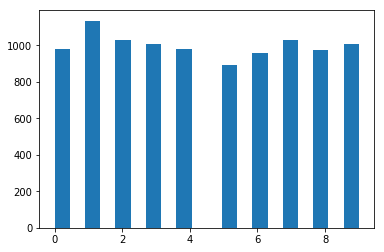

In [114]:
print("Min:", np.min(data_y))
print("Mean:", np.mean(data_y))
print("Median:", np.median(data_y))
print("Max:", np.max(data_y))
print("StdDev:", np.std(data_y))

print("Bin counts:")
print(np.bincount(data_y))

plt.hist(np.hstack(data_y), bins='auto')
plt.savefig('./test.png')
plt.show()


もう一度、Pythonの二値形式として書き込むこと、再構成を試すことにする。

In [85]:
print("Writing binary file...", end=" ")
towrite = "data/MNIST/y_te.dat"
with open(towrite, mode="bw") as g_bin:
    data_y.tofile(g_bin) # don't forget the dtype used.
print("OK.")

Writing binary file... OK.


In [86]:
with open(towrite, mode="br") as g_bin:
    data_y_check = np.fromfile(g_bin, dtype=np.uint8)
print("OK.")

print("Shapes:", data_y_check.shape, data_y.shape)
print("Difference =", np.linalg.norm(data_y_check-data_y))

OK.
Shapes: (10000,) (10000,)
Difference = 0.0


In [102]:
# c-3

data_X_float_reshaped = data_X_float.reshape((n, d))

data_X_float_reshaped_mean = data_X_float_reshaped.mean(axis=0)
data_X_float_reshaped_std = data_X_float_reshaped.std(axis=0)

data_X_float_reshaped_norm = (data_X_float_reshaped - data_X_float_reshaped_mean) / data_X_float_reshaped_std

/Users/ytakzk/.pyenv/versions/miniconda3-4.3.11/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


### 練習問題 (C):

0. 上記の一連の作業は訓練データのみでした。同じ作業を検証データに対しても行なうこと。訓練データの呼称として`X_tr`と`y_tr`（__tr__aining dataから）を使ったが、検証データは`X_te`と`y_te`と呼ぶことにしよう（__te__st dataから）。それぞれの`.dat`を先述のディレクトリーに保存しておいてください。

0. 訓練・検証データ両方の正解ラベルのヒストグラムを画像として保存してください。ラベルの分布はおおむね一様か。頻出度の高い・低い数字はそれぞれどれか。訓練と検証とではこの傾向が変わるか。

0. （おまけ）持っているデータの経験分布が平均ゼロ、分散1.0になるように標準化することが多い。画像データに対してこの操作を行なうために、まず配列の`reshape`メソッドを使って、`data_X_float`を長いベクトルから$n \times d$の行列に変換すること（$n$は標本数、$d$は一枚辺りの画素数）。各列の平均、標準偏差を算出し、適当に引き算と割り算をすること。
___

### 終わり： 後に使う関数などを`scripts/MNIST.py`に貼り付けること。